In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from utils.mask_functions import better_mask2rle, rle2mask

In [3]:


import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np



In [4]:
!ls subs

merged2_pos_alignaug_div_89_1600_our_best.csv
merged_pos_alignaug_div_89_1600_our_best.csv
submission_alighaug_1024_80_3300.csv
submission_alighaug_div89_1600.csv
submission_smp_unet_sampler_1024accum_bug.csv


In [100]:
align_div = pd.read_csv("./subs/submission_alighaug_div89_1600.csv", dtype=str)
align = pd.read_csv("./subs/submission_alighaug_1024_80_3300.csv", dtype=str)
our_best = pd.read_csv("./subs/submission_smp_unet_sampler_1024accum_bug.csv", dtype=str)

best_align = pd.read_csv("./neg_subs/submission_align_aug_tta_best.csv", dtype=str)
pos_align = pd.read_csv("./neg_subs/submission_align_aug_tta_pos.csv", dtype=str)
best_align_div = pd.read_csv("./neg_subs/submission_align_aug_div_tta_best.csv", dtype=str)
pos_align_div = pd.read_csv("./neg_subs/submission_align_aug_div_tta_pos.csv", dtype=str)
accu_bug_best = pd.read_csv("./neg_subs/submission_accum_bug_tta_best.csv", dtype=str)
accu_bug_pos = pd.read_csv("./neg_subs/submission_accum_bug_tta_pos.csv", dtype=str)

In [50]:
old_dfs = [our_best, align, align_div]
best_new_dfs = [accu_bug_best, best_align, best_align_div]
pos_new_dfs = [accu_bug_pos, pos_align, pos_align_div]

In [52]:
for df in old_dfs + best_new_dfs + pos_new_dfs:
    print((df.EncodedPixels == " -1").sum())

1175
1151
1137
1121
1169
1142
852
735
814


s


/home/inkognita/.virtualenvs/ml-py3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


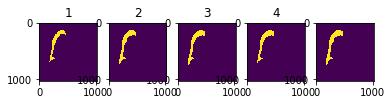

s
s
s
s
s
s


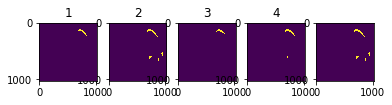

s
s
s
s
s
s
s
s
s
s
s


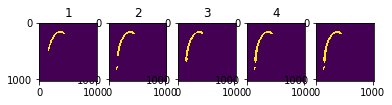

s
s
s


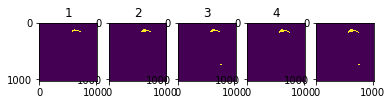

s
s
s
s
s
s


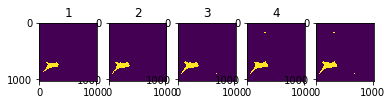

s
s


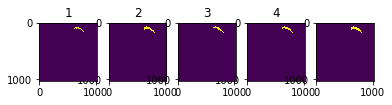

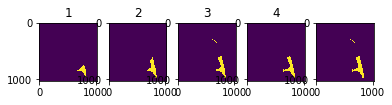

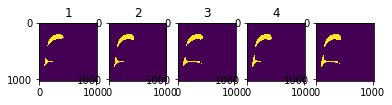

s
s


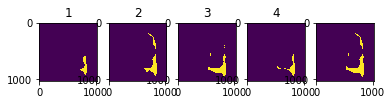

s
s


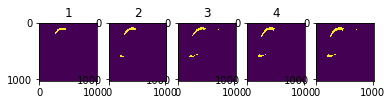

s
s
s
s
s
s
s
s
s
s
s
s
s
s
s


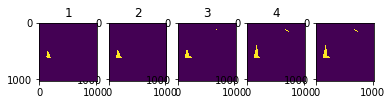

s
s
s
s


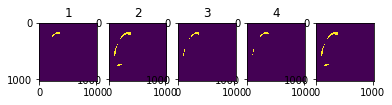

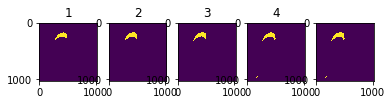

s
s
s
s
s
s
s
s
s


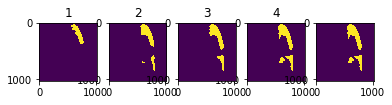

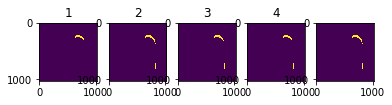

s
s
s
s
s
s
s
s
s
s


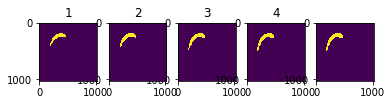

s
s
s
s
s
s
s
s
s
s


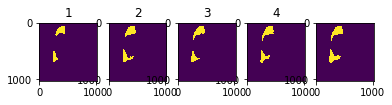

s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s


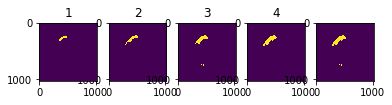

s
s
s


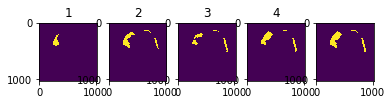

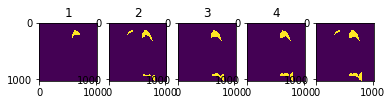

s
s


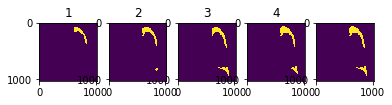

s


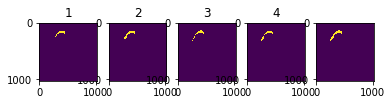

s
s
s
s
s
s


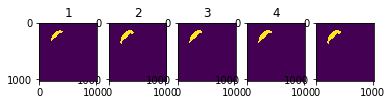

s


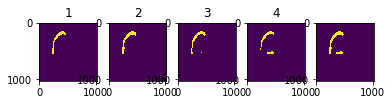

s
s
s
s
s
s
s


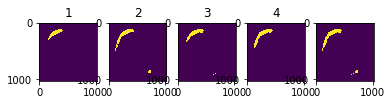

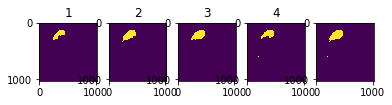

s


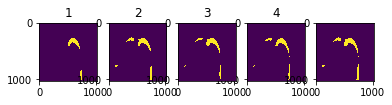

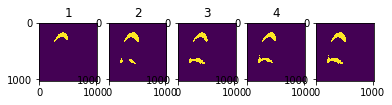

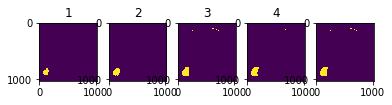

s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s


KeyboardInterrupt: 

In [73]:
dfs = [our_best] + pos_new_dfs
for img_id in align_div.ImageId.values:
    good = False
    skip = False
    or_between = None
    for i, df in enumerate(dfs):
        val = df[df.ImageId == img_id]["EncodedPixels"].values[0]
        if val.strip() == "-1":
#             mask = np.zeros((10, 10))
#             print("Empty")
            if i == 0:
                skip = True
            continue
        else:
            mask = (rle2mask(val, 1024, 1024) > 0).astype(np.uint8)
        if or_between is None:
            or_between = np.zeros_like(mask, dtype=np.bool)
        or_between |= mask > 0.5
        if skip:
            print("s")
        plt.subplot(1, len(dfs)+1, 1 + i)
        plt.title(str(i+1))
        plt.imshow(mask)
    if not skip:
        plt.subplot(1, 5, 5)
        plt.imshow(or_between)
        plt.show()


In [19]:
sample_df = pd.read_csv("subs/sample_submission.csv", dtype=str)

In [57]:
sample_non_empty = sample_df.groupby("ImageId")["ImageId"].count()
sample_non_empty = sample_non_empty[sample_non_empty > 1].index.values
sample_non_empty = set(sample_non_empty)

In [59]:
len(sample_non_empty)

78

In [45]:
for df in new_dfs:
    print((df[df.ImageId.isin(our_best[our_best.EncodedPixels == " -1"].ImageId.values)].EncodedPixels != " -1").sum())

55
28
43


In [70]:
for i, df in enumerate(old_dfs + best_new_dfs + pos_new_dfs):
    df_non_empty = set(df[df.EncodedPixels != " -1"].ImageId.values.tolist())
    inter = len(df_non_empty & sample_non_empty)
    union = len(df_non_empty | sample_non_empty)
    print(i, inter/union, inter, union, len(df_non_empty))

0 0.23893805309734514 54 226 202
1 0.22540983606557377 55 244 221
2 0.2178988326848249 56 257 235
3 0.22304832713754646 60 269 251
4 0.2324561403508772 53 228 203
5 0.23694779116465864 59 249 230
6 0.14122137404580154 74 524 520
7 0.1171875 75 640 637
8 0.13167259786476868 74 562 558


In [83]:
from tqdm import tqdm_notebook as tqdm

In [101]:
dfs = [our_best] + best_new_dfs
out_values = []
for img_id in tqdm(align_div.ImageId.unique()):
    or_between = None
    skip = False
    for i, df in enumerate(dfs):
        val = df[df.ImageId == img_id]["EncodedPixels"].values[0]
        if val.strip() == "-1":
            skip = True
            break
        mask = (rle2mask(val, 1024, 1024) > 0).astype(np.uint8)
        if or_between is None:
            or_between = np.zeros_like(mask, dtype=np.bool)
        or_between |= mask > 0.5
    if skip:
        out_values.append([img_id, "-1"])
    else:
        out_values.append([img_id, better_mask2rle(or_between * 1 * 255)])


In [102]:
out_best_values = out_values.copy()

In [103]:
out_values_df = pd.DataFrame(out_best_values, columns=['ImageId', 'EncodedPixels'])
print((out_values_df.EncodedPixels == "-1").sum())
# out_values_df.to_csv("neg_subs/merge_best.csv", index=None)

1199


In [98]:
dfs = [out_values_df] + pos_new_dfs
out_values = []
for img_id in tqdm(align_div.ImageId.unique()):
    or_between = None
    skip = False
    for i, df in enumerate(dfs):
        val = df[df.ImageId == img_id]["EncodedPixels"].values[0]
        if val.strip() == "-1":
            skip = True
            break
        mask = (rle2mask(val, 1024, 1024) > 0).astype(np.uint8)
        if or_between is None:
            or_between = np.zeros_like(mask, dtype=np.bool)
        or_between |= mask > 0.5
    if skip:
        out_values.append([img_id, "-1"])
    else:
        out_values.append([img_id, better_mask2rle(or_between * 1 * 255)])


In [99]:
best_values_df = pd.DataFrame(out_values, columns=['ImageId', 'EncodedPixels'])
print((best_values_df.EncodedPixels == "-1").sum())
best_values_df.to_csv("neg_subs/merge_pos_best.csv", index=None)

1199
